# TP RNN 
# Training language model (Many-to-Many) and generating sequences (One-to-Many)

For any remark or suggestion, please feel free to contact me at:
geoffroy.peeters@telecom-paristech.fr

Last edit: 2019/01/15 geoffroy.peeters@telecom-paristech.fr

### Objective:

- We will train a network to learn a language model and then use it to generate new sequences.

- Instead of training the language model on text-documents (as it is the case in most examples) we will train it to learn the language of the music of [Johann_Sebastian_Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach).
For this, we will learn how J. S. Bach's "Cello suite" hav been composed.
Here is an example of a "Cello suite" [Link](https://www.youtube.com/watch?v=mGQLXRTl3Z0).

- Rather than analyzing the audio signal, we use a symbolic representation of the "Cello suite" through their [MIDI files](https://en.wikipedia.org/wiki/MIDI#MIDI_files).
  - A MIDI file encodes in a file, the set of musical notes, their duration, and intensity which have to be played by each instrument to "render" a musical piece. The "rendering" is usually operated by a MIDI synthesizer (such as VLC, QuickTime).

- We will first train a language model on the whole set of MIDI files of the "Cello suites". 
- We will then sample this language model to create a new MIDI file which will be a brand new "Cello suite" composed by the computer.

### Questions:

In the bottom part of this lab, you will have to answer a set of questions. Answers to those only necessitates a couple of sentences.

## Import packages

In [0]:
import os
import pretty_midi
from scipy.io import wavfile 
import IPython

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Flatten, Dropout, Activation
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import glob

import urllib.request

In [2]:
try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.27.166.186:8470


In [0]:
def model_to_tpu(model):
  return tf.contrib.tpu.keras_to_tpu_model( model, strategy=tf.contrib.tpu.TPUDistributionStrategy(tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

In [0]:
n_x = 79
max_T_x = 1000
sequence_length = 20
T_y_generated = 200

## Collect data to create the language model

We download the 36 MIDI files corresponding to the 36 "Cello suites" composed by J. S. Bach.

In [6]:
DIR = './'

midiFile_l = ['cs1-2all.mid', 'cs5-1pre.mid', 'cs4-1pre.mid', 'cs3-5bou.mid', 'cs1-4sar.mid', 'cs2-5men.mid', 'cs3-3cou.mid', 'cs2-3cou.mid', 'cs1-6gig.mid', 'cs6-4sar.mid', 'cs4-5bou.mid', 'cs4-3cou.mid', 'cs5-3cou.mid', 'cs6-5gav.mid', 'cs6-6gig.mid', 'cs6-2all.mid', 'cs2-1pre.mid', 'cs3-1pre.mid', 'cs3-6gig.mid', 'cs2-6gig.mid', 'cs2-4sar.mid', 'cs3-4sar.mid', 'cs1-5men.mid', 'cs1-3cou.mid', 'cs6-1pre.mid', 'cs2-2all.mid', 'cs3-2all.mid', 'cs1-1pre.mid', 'cs5-2all.mid', 'cs4-2all.mid', 'cs5-5gav.mid', 'cs4-6gig.mid', 'cs5-6gig.mid', 'cs5-4sar.mid', 'cs4-4sar.mid', 'cs6-3cou.mid']
for midiFile in midiFile_l:
  #if os.path.isfile(DIR + midiFile) is None:
  urllib.request.urlretrieve ("http://www.jsbach.net/midi/" + midiFile, DIR + midiFile)
nbExample = len(midiFile_l)

midiFile_l = glob.glob(DIR + 'cs*.mid')
print(midiFile_l)

['./cs2-1pre.mid', './cs4-3cou.mid', './cs6-1pre.mid', './cs1-1pre.mid', './cs2-5men.mid', './cs1-6gig.mid', './cs1-3cou.mid', './cs6-6gig.mid', './cs4-2all.mid', './cs2-2all.mid', './cs2-3cou.mid', './cs3-4sar.mid', './cs3-5bou.mid', './cs2-4sar.mid', './cs3-6gig.mid', './cs6-4sar.mid', './cs5-5gav.mid', './cs6-5gav.mid', './cs3-2all.mid', './cs2-6gig.mid', './cs1-2all.mid', './cs5-6gig.mid', './cs4-5bou.mid', './cs3-1pre.mid', './cs5-3cou.mid', './cs6-2all.mid', './cs3-3cou.mid', './cs4-6gig.mid', './cs1-5men.mid', './cs5-1pre.mid', './cs5-2all.mid', './cs6-3cou.mid', './cs4-4sar.mid', './cs5-4sar.mid', './cs1-4sar.mid', './cs4-1pre.mid']


## Read and convert all MIDI files

We read all MIDI files and convert their content to one-hot-encoding matrix X_ohe of dimensions (T_x, n_x) where n_x is the number of possible musical notes.
The duration of the sequences T_x can vary from one sequence to the other.
 


In [7]:
# We truncate the duration of each example to the first T_x data

X_list = []

for midiFile in midiFile_l:
    # read the MIDI file
    midi_data = pretty_midi.PrettyMIDI(midiFile)
    note_l = [note.pitch for note in midi_data.instruments[0].notes]
    # convert to one-hot-encoding
    T_x = len(note_l)
    if T_x > max_T_x:
      T_x = max_T_x
    X_ohe = np.zeros((T_x, n_x))
    for t in range(T_x): 
      X_ohe[t, note_l[t]-1] = 1
    # add to the list  
    X_list.append(X_ohe)
    
print(len(X_list))
print(X_list[0].shape)
print(X_list[1].shape)
print(X_list[2].shape)

36
(634, 79)
(902, 79)
(1000, 79)


## Display the set of notes over time for a specific track 

In [10]:
plt.figure(figsize=(16, 6))
plt.imshow(X_list[2].T, aspect='auto')
plt.set_cmap('gray_r')
plt.grid(True)

## Data conversion for the training of language model

For each example/sequence and each possible starting note in this example/sequence, we create two sequences
- an input sequence: 
  - which contains a sub-sequence of length ```sequence_length```;  this sub-sequence range from the note $t$ to the note $t+sequence\_length-1$
- an output sequence:
  - which contains the following note to be predicted, the one at position $t+sequence\_length$

The training is therefore performed by giving to the model a set of sequences as input and asking the network to predict each time the note that should come right after this sequence.

In [11]:
X_train_list = []
y_train_list = []

# CODE-RNN2-1
# --- START CODE HERE

X_train_list = [X_list[i][t:t+sequence_length, :] for i in range(len(X_list)) for t in range(len(X_list[i])-sequence_length)]
y_train_list = [X_list[i][t+sequence_length, :] for i in range(len(X_list)) for t in range(len(X_list[i])-sequence_length)]
  
# --- END CODE HERE

X_train = np.asarray(X_train_list)
y_train = np.asarray(y_train_list)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)

X_train.shape: (23781, 20, 79)
y_train.shape: (23781, 79)


# Training the language model

The language model will be learned by training an RNN with input ```X_train``` and output ```Y_train```:  for each of the examples of sequences, we give to the network a sequence of notes of ```sequence_length``` duration, and ask the network to predict the following note of each sequence.

The network will have the following structure
- a layer of ```LSTM``` with $n_a$=256
- a DropOut layer with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- a second layer of ```LSTM``` with $n_a$=256
- a DropOut layer with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- a ```Dense``` layer with 256 units
- a DropOut layer with rate 0.3 (the probability to "drop-out" one neuron is 0.3)
- a third layer of LSTM with  𝑛𝑎 =256
- a ``Dense``` layer with a ```softmax``` activation which predict the probability of each of the $n_x$ notes as output

Note that because we will stack two LSTM layers on top of each other (deep-RNN), we need to tell the first LSTM to output its hidden states at each time $t$. This is done by the option ```return_sequences=True``` that has to be given to the first LSTM.

This is not the case of the second LSTM since we are only interrest in its final prediction (hence ```return_sequences=False``` which is the default behaviour).

In [19]:
# create the model
K.clear_session()

# CODE-RNN2-2
# --- START CODE HERE
model = Sequential()

model.add(LSTM(256, return_sequences=True, input_shape=(20, 79)))
model.add(Dropout(0.3))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(256, return_sequences=False ))

model.add(Dense(256))

model.add(Dense(79, activation='softmax'))
# --- END CODE HERE

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 256)           344064    
_________________________________________________________________
dropout (Dropout)            (None, 20, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dense_1 (Dense)              (None, 79)                20303     
Total para

In [20]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model = model_to_tpu(model)

model.fit(X_train, y_train, epochs=50, batch_size=64)

INFO:tensorflow:Querying Tensorflow master (grpc://10.27.166.186:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 8876020718377546830)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17963023488845868977)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 1362391889716860301)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 2035164104335264906)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 5781978348225323969)
INFO:tensorflow:*** Available Device: _DeviceAttributes(

# Generating a new sequence from sampling the language model

To generate a new sequence from the language model, we simply give it as input a random sequence of duration ```sequence_length``` and ask the trained network to predict the output (using ```model.predict```). 

The output of the network is a vector of probability of dimension $n_x$ which represents the probability of each note to be the next note of the melody given as input.

From this vector, we select the note which has the maximum probability.

We then concatenate this new note (its one-hot-encoding representation) at the end of the input sequence.
We finally remove the first element of the input sequence to keep its duration constant (```sequence_length```).

Instead of providing a random sequence as input, we rather randomly select one sequence out of the 2880 sequences used for training.
We denote it by ```pattern```.



In [21]:
# --- select a random starting pattern
start = np.random.randint(0, len(X_train_list)-1)
pattern = X_train_list[start]
print(start)
print(pattern.shape)
print(np.expand_dims(pattern, 0).shape)

11777
(20, 79)
(1, 20, 79)


In [22]:
note_l = []
prediction_l = []

cpu_model = model.sync_to_cpu()

# generate T_y_generated notes
for note_index in range(T_y_generated):
  
    # CODE-RNN2-3
    # --- START CODE HERE
    
    y_pred = cpu_model.predict(np.expand_dims(pattern[note_index:,:], 0))
    
    prediction_l.append(y_pred)
    
    # Note
    note = np.argmax(y_pred)
    note_l.append(note)
    
    note_intermediate = np.zeros(79)
    note_intermediate[note] = 1
    
    pattern = np.vstack((pattern,note_intermediate))
    
    # --- END CODE HERE


INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 0.0010000000474974513
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 0.0
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False


### Display the generated sequence

[51, 52, 44, 46, 52, 51, 53, 54, 56, 58, 59, 61, 63, 65, 59, 49, 59, 65, 59, 58, 61, 63, 65, 66, 58, 56, 66, 65, 49, 54, 58, 59, 61, 63, 54, 53, 63, 61, 46, 51, 54, 56, 58, 59, 51, 49, 59, 58, 42, 47, 46, 47, 51, 46, 47, 53, 51, 53, 47, 46, 47, 54, 53, 54, 47, 46, 47, 56, 54, 56, 47, 46, 49, 51, 53, 54, 61, 59, 53, 51, 53, 44, 42, 46, 47, 49, 51, 58, 56, 49, 47, 49, 41, 39, 42, 44, 46, 47, 54, 53, 56, 58, 59, 61, 47, 46, 54, 37, 53, 54, 58, 59, 61, 54, 56, 58, 54, 49, 53, 54, 54, 56, 58, 59, 58, 56, 54, 52, 51, 54, 52, 51, 49, 47, 42, 40, 39, 37, 35, 47, 49, 51, 52, 51, 49, 51, 54, 49, 47, 46, 47, 54, 46, 44, 42, 54, 52, 51, 52, 54, 51, 44, 54, 59, 51, 52, 51, 49, 51, 52, 49, 42, 52, 58, 49, 51, 49, 47, 49, 51, 47, 40, 44, 46, 47, 49, 52, 51, 47, 42, 46, 47, 35, 51, 49, 47, 46, 47, 51, 53]


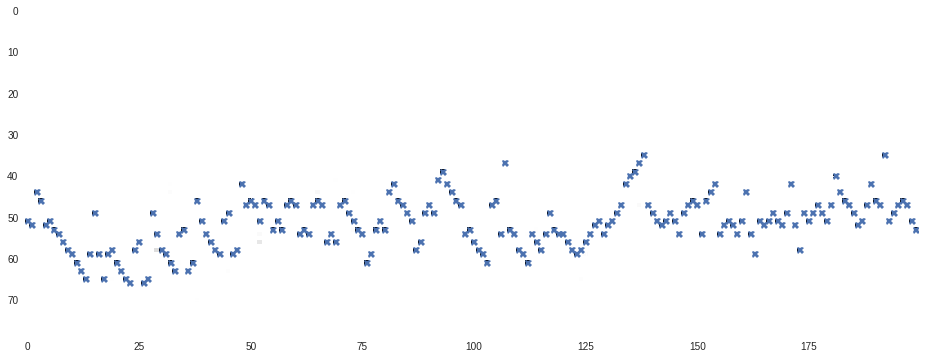

In [23]:
print(note_l)

plt.figure(figsize=(16, 6))
plt.imshow(np.asarray(prediction_l)[:,0,:].T, aspect='auto')
plt.plot(note_l, 'X')
plt.set_cmap('gray_r')
plt.grid(True)

### Create a MIDI file and an audio file which correspond to the generated sequence

Once the new sequence has been generated (```note_l```) we transform it to a new MIDI file and perform (a very cheap) rendering of it in an audio file.

In [24]:
new_midi_data = pretty_midi.PrettyMIDI()
cello_program = pretty_midi.instrument_name_to_program('Cello')
cello = pretty_midi.Instrument(program=cello_program)
time = 0
step = 0.3
for note_number in note_l:
    myNote = pretty_midi.Note(velocity=100, pitch=note_number, start=time, end=time+step)
    cello.notes.append(myNote)
    time += step
new_midi_data.instruments.append(cello)
%matplotlib inline

audio_data = new_midi_data.synthesize()
IPython.display.Audio(audio_data, rate=44100)

### Question 1) Que se passe-t'il si on remplace la cellule LSTM par une cellule RNN simple ?

Réponse :

Les cellules RNN simples ont des difficultés à prendre en compte les dépendances de long terme à cause de la décroissance exponentielle du gradient. Pour cette raison, les cellules LSTM sont préférables, car la musique produite dépendra de toute la séquence donnée et entrée et évitera de converger vers une seule et même séquence répétée en prédiction.

### Question 2) Que se passe-t'il si l'on raccourci la longueur des séquences utilisées pour l'entrainement ? Comment palier à cet effet ?

Réponse :

Dans ce cas, on risque d'overfitter sur le petit échantillon dont l'on dispose. On estime des centaines de milliers de paramètres, sans pour autant avoir suffisament de données en entrée. La partie de l'input qui nous sert comme donnée d'entrée à la prédiction est donc plus faible. On a un système qui dépend donc d'avantage de la prédiction elle-même pour les notes suivantes. On risque de converger vers une séquence donnée. Des échantillons bootstrap séquentiels permettraient de palier à cet effet par exemple, et de la régularisation (dropout) .

### Question 3) Comment pourrait-on rendre le système ```polyphonique``` (plusieurs notes jouées simultanément par le même instrument) ? pour l'entrainement ? pour la génération ?

Réponse :

Il faut une entrée polyphonique. On peut modifier l'architecture de notre réseau de sorte à avoir une couche d'activation de type Sigmoid qui décide de l'activation ou non d'une note produite parmi les 79 notes diponibles. On peut alors déterminer un seuil à appliquer sur la sortie par exemple pour décider des notes activées que l'on joue ou non. 

Une approche similaire est développée dans ce papier : https://qmro.qmul.ac.uk/xmlui/bitstream/handle/123456789/24946/Benetos%20A%20study%20on%20LSTM%202017%20Accepted.pdf?sequence=1

### Question 4) Nous avons utilisé une procédure simplifiée pour entrainer le modèle de language musical, en transformant l'apprentissage en un problème Many-To-one. Expliquez ? Comment entraine-t'on habituellement un modèle de language avec un RNN ? Quel en serait l'avantage ?

Réponse :

L'approche Many-To-One consiste à prendre en entrée une série d'inputs de longueur > 1 et d'en sortir un output unique.

Habituellement, les modèles de langage sont de type many-to-many. On utilise une séquence d'entrée pour prédire une séquence de sortie. L'avantage sera alors de produire plusieurs notes d'un coup, et donc d'éviter potentiellement de devoir prédire chaque nouvelle note à jouer. On gagnerait en temps de calcul typiquement. De plus, les prédictions précédentes des notes ne rentrent pas en compte pour la prédiction de la note suivante. Il y a une cohérence au niveau de la prédiction que l'on effectue.